In [1]:
# Import packages
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import shutil

In [2]:
# Define constants

# Define number of classes to use (this is a way to subset the data)
CLASS_NUM = 3

BATCH_SIZE = 32

## Data Preprocessing

Because the train set is big (`train_dir`), we take a subset of classes defined by `CLASS_NUM` and copy the images belonging to that subset of classes to our working directory (`subset_dir`). Initially, we will train the model using only this subset.

In [3]:
# Store paths to base, train set and subset dirs
base_dir = "/kaggle/input/imagenet-object-localization-challenge"
train_dir = base_dir + "/ILSVRC/Data/CLS-LOC/train"
subset_dir = "/kaggle/working/data"

if not os.path.exists(subset_dir):
    os.mkdir(subset_dir)
    print(subset_dir, "created!")
else:
    print(subset_dir, "already exists!")
    
# Select only first n class dirs
class_dirs = os.listdir(train_dir)[:CLASS_NUM]

# Copy class dir from train set to working dir
for class_dir in class_dirs:
    # Define current source and destination paths
    source_dir = train_dir + "/" + class_dir
    destination_dir = subset_dir + "/" + class_dir
    
    # If new class, copy to working dir
    if not os.path.exists(destination_dir):
        shutil.copytree(source_dir, destination_dir)
        print(class_dir, "succesfully copied!")
    # If it exists, don't copy again
    else:
        print(class_dir, "doesn't need copying!")

/kaggle/working/data created!
n01531178 succesfully copied!
n02412080 succesfully copied!
n02098413 succesfully copied!


Now that the images were copied in our working directory, we try to open one as a sanity check. Which animal did you find?

(400, 500, 3)


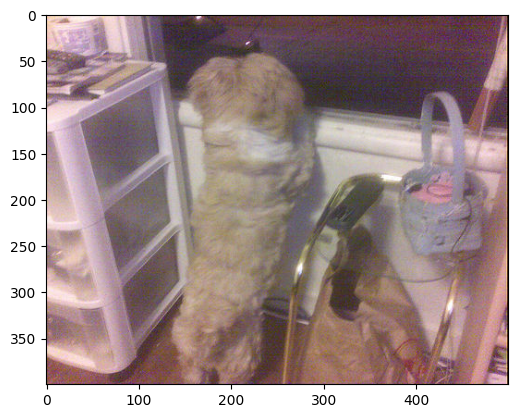

In [4]:
from matplotlib import pyplot as plt
from matplotlib import image

# Read in image
image = image.imread(subset_dir + "/n02098413/n02098413_720.JPEG")
# Show image
plt.imshow(image)
print(np.shape(image))

Then, we import our train set with keras utils. We are now ready to use it to train a model!

In [5]:
# Import train set as a Dataset object
# (this object type can be used as input to the model)
raw_train_set = tf.keras.utils.image_dataset_from_directory(subset_dir, image_size=(224, 224))

Found 3900 files belonging to 3 classes.


## Model Design

In [6]:
# Normalise images to [0-1] scale
train_set = raw_train_set.map(lambda x, y: (x / 255, y))
# Separate images and labels
images, labels = next(iter(train_set))

# Prepare data for training
X_train = images
y_train = pd.get_dummies(labels)

# Set input shape (this is not working)
input_shape = X_train.shape[1:]
input_shape

TensorShape([224, 224, 3])

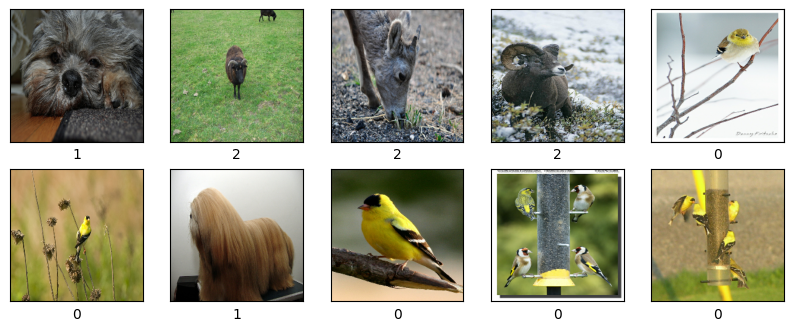

In [7]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(int(labels[i]))
plt.show()

In [8]:
model_11 = tf.keras.models.Sequential()
model_11.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3),padding= "same")) #conv3-64 layer 1
model_11.add(tf.keras.layers.MaxPooling2D((2, 2), strides = (2,2))) #maxpool 1
model_11.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu',padding= "same")) #conv3-128 layer 2
model_11.add(tf.keras.layers.MaxPooling2D((2, 2), strides = (2,2))) #maxpool 2
model_11.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu',padding= "same")) #conv3-256 layer 3
model_11.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu',padding= "same")) #conv3-256 again layer 4
model_11.add(tf.keras.layers.MaxPooling2D((2, 2), strides = (2,2))) #maxpool 3
model_11.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu',padding= "same")) #conv3-512 layer 5
model_11.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu',padding= "same")) #conv3-512 again layer 6
model_11.add(tf.keras.layers.MaxPooling2D((2, 2), strides = (2,2))) #maxpool 4
model_11.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu',padding= "same")) #conv3-512 - second round layer 7
model_11.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu',padding= "same")) #conv3-512 again layer 8
model_11.add(tf.keras.layers.MaxPooling2D((2, 2), strides = (2,2))) #maxpool 5 - final

model_11.add(tf.keras.layers.Flatten()) #necessary for 1D Dense layer
model_11.add(tf.keras.layers.Dense(4096, activation='relu')) # FC 1 layer 9
model_11.add(tf.keras.layers.Dropout(0.5))
model_11.add(tf.keras.layers.Dense(4096, activation='relu')) #FC 2 layer 10
model_11.add(tf.keras.layers.Dropout(0.5))
model_11.add(tf.keras.layers.Dense(3, activation='relu')) # FC 3 layer 11
model_11.add(tf.keras.layers.Softmax())

model_11.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 256)       295168    
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 256)       5

In [9]:
# Choose optimiser, loss function and validation metric
LR_Decay = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.1,
    patience=2,
    mode='auto',
    min_delta=0.0001,
    min_lr=0.00001
)

model_11.compile(optimizer = tf.keras.optimizers.experimental.SGD(
    learning_rate=0.01,
    momentum=0.90,
    nesterov=False,
    weight_decay=0.0005,
),  loss="categorical_crossentropy",
    metrics=["categorical_accuracy"]
                )

In [10]:
# Train the model
history = model_11.fit(
    X_train, y_train,
    epochs=2,
    batch_size=10,
    verbose=True,
    callbacks=[LR_Decay]
)

# Store training history as a dataframe
history_df = pd.DataFrame(history.history)

print(f"Train loss: {history_df['loss'].iloc[-1]:.3f}")
print(f"Train accuracy: {history_df['categorical_accuracy'].iloc[-1]:.3f}")

Epoch 1/2
4/4 [==============================] - 19s 4s/step - loss: 1.0994 - categorical_accuracy: 0.3125 - lr: 0.0100
Epoch 2/2
4/4 [==============================] - 17s 4s/step - loss: 1.0989 - categorical_accuracy: 0.4062 - lr: 0.0100
Train loss: 1.099
Train accuracy: 0.406


Text(0, 0.5, 'Accuracy')

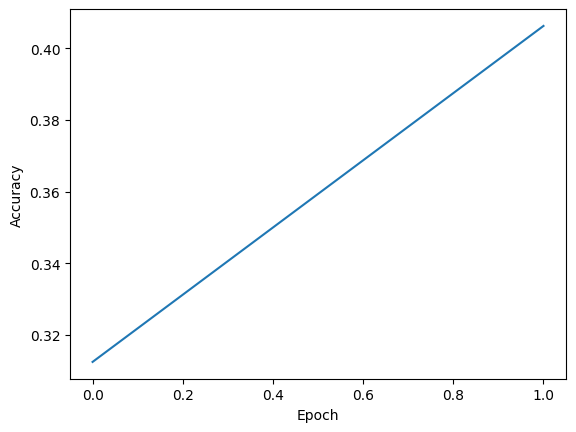

In [11]:
plt.plot(history.history['categorical_accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.legend(loc='lower right')

In [12]:
'''model_11.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))'''

"model_11.compile(optimizer='adam',\n              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),\n              metrics=['categorical_accuracy'])\n\nhistory = model.fit(train_images, train_labels, epochs=10, \n                    validation_data=(test_images, test_labels))"

In [13]:
'''plt.plot(history.history['categorical_accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels)'''

"plt.plot(history.history['categorical_accuracy'], label='accuracy')\nplt.plot(history.history['val_accuracy'], label = 'val_accuracy')\nplt.xlabel('Epoch')\nplt.ylabel('Accuracy')\nplt.ylim([0.5, 1])\nplt.legend(loc='lower right')\n\ntest_loss, test_acc = model.evaluate(test_images,  test_labels)"